<a href="https://colab.research.google.com/github/IlyaTyagin/MLTSA22_ITyagin/blob/main/HW7/HW7_Ilya_Tyagin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This is an exercise on feature extractoin and Gaussian Processes interpolation of sparse time series.

## OVERVIEW

The PLAsTiCC challend is a Kaggle challange to classify astrophysical objects (e.g. stars, exploding stars, stars with planets transiting, black holes) based on their time variability in light emission in 6 different bands (i.e. wavelength ranges). The sampling (the cadence of the observations) is designed to show what the upcming Rubin Observatory LSST (Legacy Survey of Space and Time) will see when it starts observing (in 2023). 

You can refer to this notebook https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit (written by my good friend Gautham Narayan) to get started and ingest and preprocess the PLASTiCC challenge data. If you are not familiar with classes (object oriented syntax) do not worry about it: I do want you to extract the features yourself. So use it as a guideline, but do not just copy and paste.

Your task is to extract features, i.e. representations of the time series, and fit the time series with Gaussian Processes. 



In [217]:
import pandas as pd
import numpy as np
import pylab as pl
import random
from scipy import stats
from tqdm import tqdm
from collections import defaultdict
tqdm.pandas()

%pylab inline


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
pl.rcParams['figure.figsize'] = (15, 10)

# TASK I :  Data Acquisition
 You can download the data from kaggle
 --- https://www.kaggle.com/c/PLAsTiCC-2018
 or from zenodo
 --- https://zenodo.org/record/2539456#.XonrIdNKjOQ
 Choose how to do it but make sure that it is a reproducible way. You will need the **training data and the metadata files** only - you wont need to use the test data


In [ ]:
lcvs = pd.read_csv(
    """https://zenodo.org/record/2539456/files/plasticc_train_lightcurves.csv.gz?download=1""", 
    compression='gzip'
    )

In [ ]:
lcvs.columns

Index(['object_id', 'mjd', 'passband', 'flux', 'flux_err', 'detected_bool'], dtype='object')

In [ ]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [ ]:
lcvs.rename(
    columns={
        'detected_bool': 'detected'
    },
    inplace=True,
  )

In [ ]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [ ]:
print("The shape of light curves dataset is:", lcvs.shape)

The shape of light curves dataset is: (1421705, 6)


In [ ]:
#check missing values
lcvs.isna().sum()

object_id    0
mjd          0
passband     0
flux         0
flux_err     0
detected     0
dtype: int64

Read the Kaggle challenge for a description of the data . This "Starter Kit" which includes a notebook (written by y good friend Gautham Narayan) may be especially useful
https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit

For each object there are 6 time series in 6 different passbands 

In [ ]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [ ]:
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".format(objects.shape[0]))

There are 7848 astrophysical simulated objects in my dataset


In [ ]:
metadata = pd.read_csv(
    """https://zenodo.org/record/2539456/files/plasticc_train_metadata.csv.gz?download=1""", 
    compression='gzip'
    )

In [ ]:
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,...,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,...,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,...,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,...,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,...,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print("The metadata columns are: ", metadata.columns)

The metadata columns are:  Index(['object_id', 'ra', 'decl', 'ddf_bool', 'hostgal_specz',
       'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target',
       'true_target', 'true_submodel', 'true_z', 'true_distmod',
       'true_lensdmu', 'true_vpec', 'true_rv', 'true_av', 'true_peakmjd',
       'libid_cadence', 'tflux_u', 'tflux_g', 'tflux_r', 'tflux_i', 'tflux_z',
       'tflux_y'],
      dtype='object')


In [ ]:
print("The metadata dataset contains features: ", metadata.shape[1])

The metadata dataset contains features:  26


# TASK II : data exploration and visualization - plot some time series 
Visualize my data to get a sense of what we are working with. 





In [ ]:
pip install astropy

In [ ]:
from astropy.table import Table
import scipy.stats as spstat

In [ ]:
class LightCurve(object):
    '''Light curve object for PLAsTiCC formatted data'''
    
    _passbands = dict([(0,'C4'),\
                      (1,'C2'),\
                      (2,'C3'),\
                      (3,'C1'),\
                      (4,'k'),\
                      (5,'C5')])
    
    _pbnames = ['u','g','r','i','z','y']
    
    def __init__(self, filename, obj_name):
        '''Read in light curve data'''

        #self.DFlc     = Table.read(filename, format='ascii.csv')
        #self.filename = filename.replace('.csv','')

        self.DFlc = filename
        self.filename = obj_name

        self._finalize()
     
    # this is some simple code to demonstrate how to calculate features on these multiband light curves
    # we're not suggesting using these features specifically
    # there also might be additional pre-processing you do before computing anything
    # it's purely for illustration
    def _finalize(self):
        '''Store individual passband fluxes as object attributes'''
        # in this example, we'll use the weighted mean to normalize the features
        weighted_mean = lambda flux, dflux: np.sum(flux*(flux/dflux)**2)/np.sum((flux/dflux)**2)
        
        # define some functions to compute simple descriptive statistics
        normalized_flux_std = lambda flux, wMeanFlux: np.std(flux/wMeanFlux, ddof = 1)
        normalized_amplitude = lambda flux, wMeanFlux: (np.max(flux) - np.min(flux))/wMeanFlux
        normalized_MAD = lambda flux, wMeanFlux: np.median(np.abs((flux - np.median(flux))/wMeanFlux))
        beyond_1std = lambda flux, wMeanFlux: sum(np.abs(flux - wMeanFlux) > np.std(flux, ddof = 1))/len(flux)
        
        for pb in self._passbands:
            ind = self.DFlc['passband'] == pb
            pbname = self._pbnames[pb]
            
            if len(self.DFlc[ind]) == 0:
                setattr(self, f'{pbname}Std', np.nan)
                setattr(self, f'{pbname}Amp', np.nan)
                setattr(self, f'{pbname}MAD', np.nan)
                setattr(self, f'{pbname}Beyond', np.nan)
                setattr(self, f'{pbname}Skew', np.nan)
                continue
            
            f  = self.DFlc['flux'][ind]
            df = self.DFlc['flux_err'][ind]
            m  = weighted_mean(f, df)
            
            # we'll save the measurements in each passband to simplify access.
            setattr(self, f'{pbname}Flux', f)
            setattr(self, f'{pbname}FluxUnc', df)
            setattr(self, f'{pbname}Mean', m)
            
            # compute the features
            std = normalized_flux_std(f, df)
            amp = normalized_amplitude(f, m)
            mad = normalized_MAD(f, m)
            beyond = beyond_1std(f, m)
            skew = spstat.skew(f) 
            
            # and save the features
            setattr(self, f'{pbname}Std', std)
            setattr(self, f'{pbname}Amp', amp)
            setattr(self, f'{pbname}MAD', mad)
            setattr(self, f'{pbname}Beyond', beyond)
            setattr(self, f'{pbname}Skew', skew)
        
        # we can also construct features between passbands
        pbs = list(self._passbands.keys())
        for i, lpb in enumerate(pbs[0:-1]):
            rpb = pbs[i+1]
            
            lpbname = self._pbnames[lpb]
            rpbname = self._pbnames[rpb]
            
            colname = '{}Minus{}'.format(lpbname, rpbname.upper())
            lMean = getattr(self, f'{lpbname}Mean', np.nan)
            rMean = getattr(self, f'{rpbname}Mean', np.nan)
            col = -2.5*np.log10(lMean/rMean) if lMean> 0 and rMean > 0 else -999
            setattr(self, colname, col)
    
    # this is a simple routine to visualize a light curve
    # it can plot vs the MJD array of the light curve
    # or vs an optional `phase` array that you pass 
    def plot_multicolor_lc(self, phase=None):
        '''Plot the multiband light curve'''

        fig, ax = plt.subplots(figsize=(8,6))

        
        if phase is None:
            phase = []
        if len(phase) != len(self.DFlc):
            phase = self.DFlc['mjd']
            xlabel = 'MJD'
        else:
            xlabel = 'Phase'
            
        for i, pb in enumerate(self._passbands):
            pbname = self._pbnames[pb]
            ind = self.DFlc['passband'] == pb
            if len(self.DFlc[ind]) == 0:
                continue
            ax.errorbar(phase[ind], 
                     self.DFlc['flux'][ind],
                     self.DFlc['flux_err'][ind],
                     fmt = 'o', color = self._passbands[pb], label = f'{pbname}')
        ax.legend(ncol = 4, frameon = True)
        ax.set_xlabel(f'{xlabel}', fontsize='large')
        ax.set_ylabel('Flux', fontsize='large')
        fig.suptitle(self.filename, fontsize='x-large')
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    
    def get_features(self):
        '''Return all the features for this object'''
        variables = ['Std', 'Amp', 'MAD', 'Beyond', 'Skew']
        feats = []
        for i, pb in enumerate(self._passbands):
            pbname = self._pbnames[pb]
            feats += [getattr(self, f'{pbname}{x}', np.nan) for x in variables]
        return feats

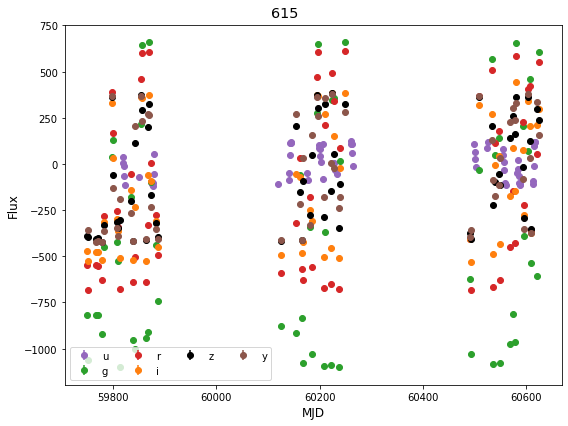

In [ ]:
LightCurve(
    lcvs[lcvs['object_id'] == 615],
    obj_name = '615'
).plot_multicolor_lc()

Plot light curves for 10 objects. 

In [ ]:
np.random.seed(42)

In [ ]:
obj_sample = np.random.choice(objects, 10)

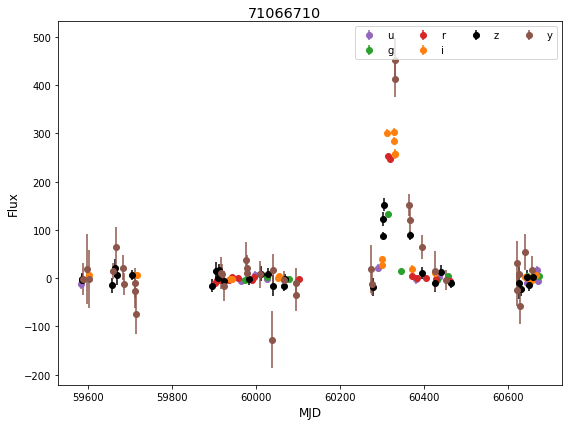

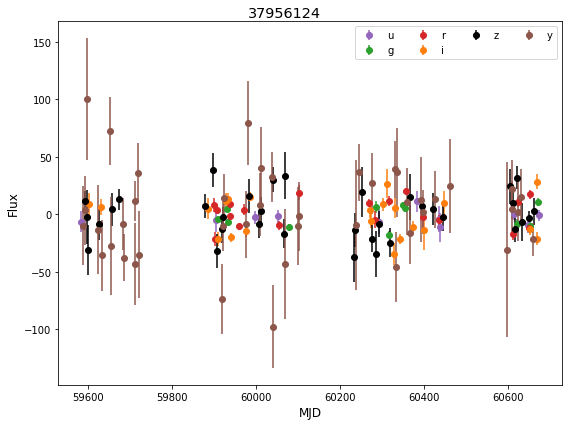

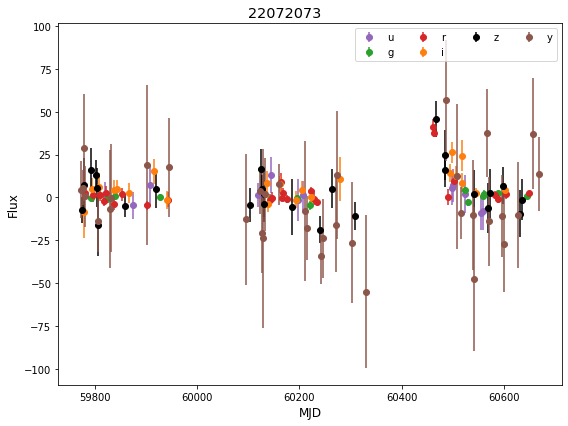

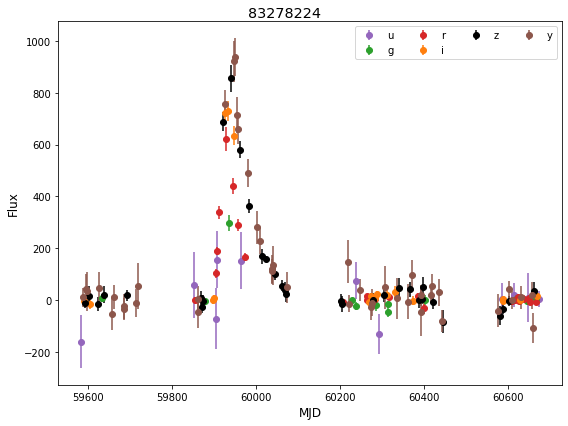

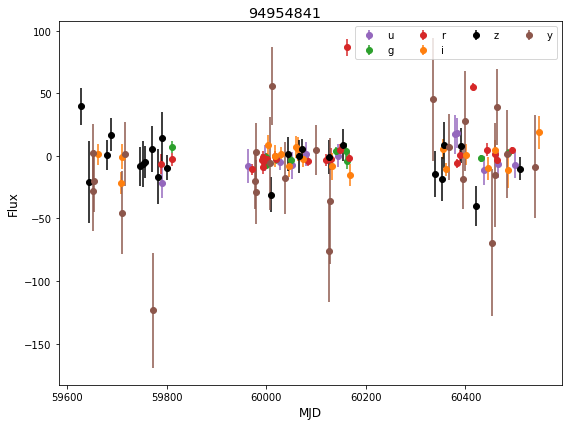

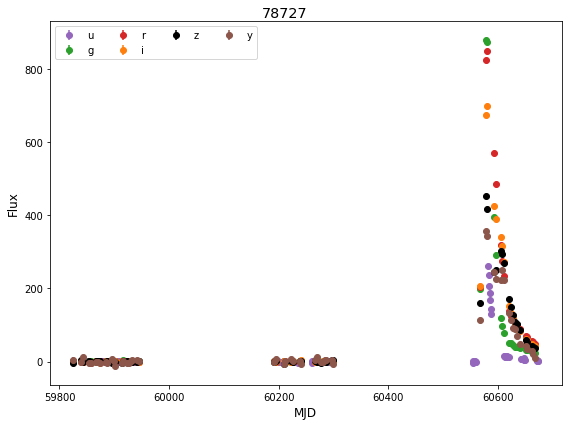

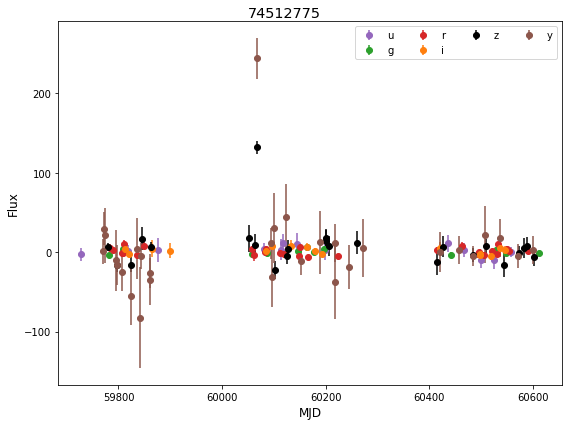

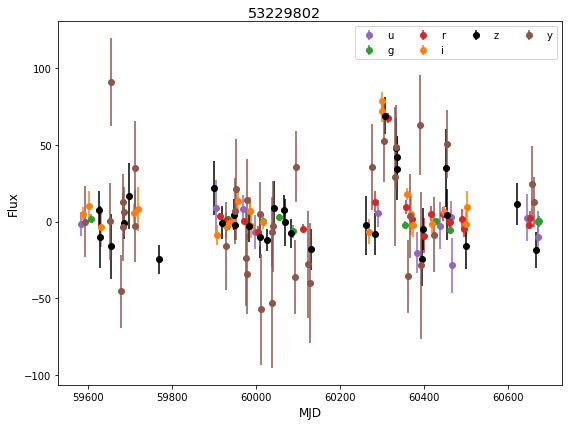

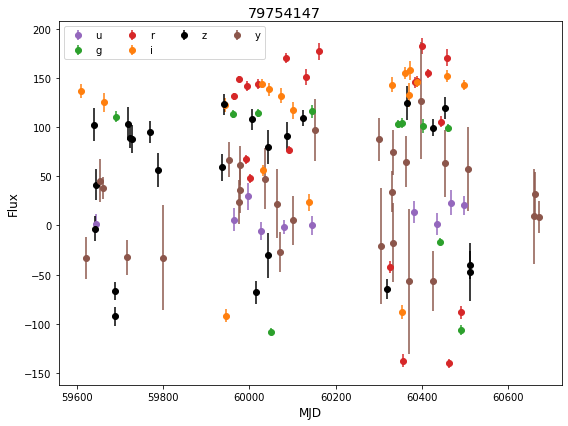

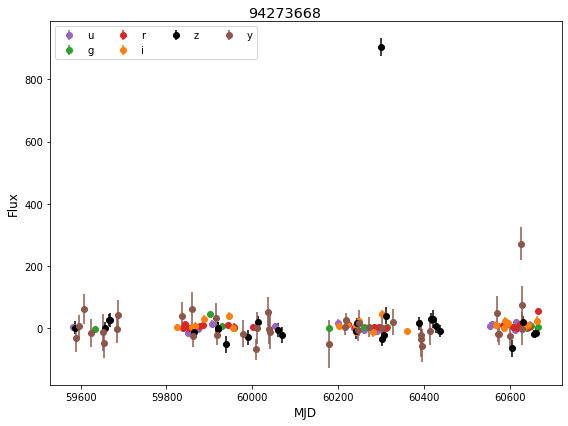

In [ ]:
for obj_id in obj_sample:
  LightCurve(
    lcvs[lcvs['object_id'] == obj_id],
    obj_name = obj_id
).plot_multicolor_lc()

Plot explicitly object 84716

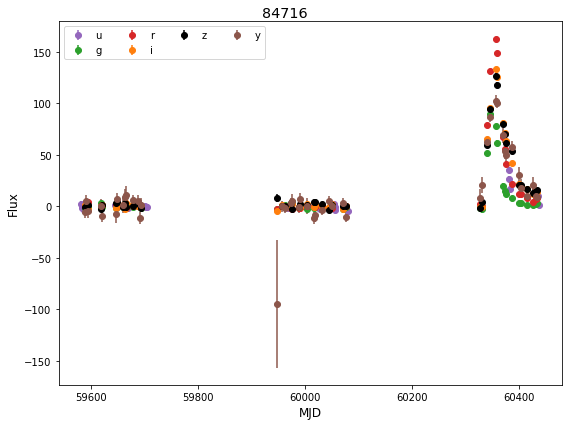

In [ ]:
obj_id = 84716
LightCurve(
  lcvs[lcvs['object_id'] == obj_id],
  obj_name = obj_id
).plot_multicolor_lc()

# TASK III: Extract features

Feature extraction refers to the extraction of statistical features of the datapoints or the generation of low dimensional representations of the data points that can then be passed to a classifier/regression

Extract at least 4 features including at least 1 feature from all three category below

The code that won the callenge did a number of smart things, of course. It was a feature based classification scheme, which included Gaussian Processes in the preprocessing. The feature extraction part of the code is here. https://github.com/kboone/avocado/blob/master/avocado/plasticc.py

Examples of features you can extract:

- **from the original lightcurve**: 
    - mean, 
    - standard deviation, 
    - skewness, 
    - kurthosis, 
    - minimum 
    - maximmum,
    - error on the minimum and 
    - error on the maximum, 
- **from the standardized lightcurve**:
    - median 
    - slope of a line fit
    - intercept of a line fit
    - likelihood of the line fit
    - likelihood of a quadratic fit
    - sign of the quadratic parameter


- **from the metadata file**:
    - decl; this is one of the positions in the sky variables: important because the position on the sky may determin if it is a galactic or extragalactic object
    - ddf_bool ; the kind of survey i.e. the data collection scheme that lead to the time series
    - hostgal_photoz
    - hostgal_photoz_err
    
The feature in the metadata files are the hardest ones to decide on because they require domain knowledge.
Most of the other features in the metadata are unknown for test objects (only known for the training set)


Extract at least 4 features including 1 features from all three category above: original lcv, standardized lcv, metadata. Justify each feature. Coming up with different features than the ones I suggested is very welcome! Remember that if the features are extracted from the time series there will be 4 features for each passbands.

Note: we are working with bigg-ish data! 
First off: every new piece should be developed on a subset of the dataset, then run on all the data only when ready. 
Still, if you try achieve goals by implementing for loops you are not going to be able to run the notebook for the whole data, or even only 1 batch of the full datase. A good solution is to use the groupby() method in pandas. I used groupby everywhere. Also it may be wise to write out intermediate outputs, so you do not have to loose work if your kernel dies or something similar. 


describe each feature you plan to extract. Briefly indicate why you think it is a valuable feature and what data type is it (e.g. continuous, binary, categorical, if continuous does it have a max or min value or is it unbound?)

        

In [ ]:
lcvs_small = lcvs[lcvs['object_id'].isin(obj_sample)]
lcvs_small

,object_id,mjd,passband,flux,flux_err,detected_bool
153205,78727,59825.2600,2,0.274491,0.935516,0
153206,78727,59825.2676,1,-0.660713,1.016105,0
153207,78727,59825.2752,3,1.436949,1.877900,0
153208,78727,59825.2862,4,-2.984961,2.987549,0
153209,78727,59825.2971,5,4.670087,7.129139,0
...,...,...,...,...,...,...
1219259,94954841,60493.0784,2,4.340096,2.944154,0
1219260,94954841,60498.9839,0,-7.680009,10.437799,0
1219261,94954841,60510.0052,4,-10.361254,9.096044,0
1219262,94954841,60538.9909,5,-8.717340,41.278408,0


In [ ]:
def agg_norm_flux(x):
  """ func that normalizes flux and flux_err values.
  
  x - pandas groupby object (over obj_id and passband)
  """
  x['flux_norm'] = (
      np.array(x['flux']) - np.mean(x['flux'])
      )/np.std(x['flux'])
  x['flux_err_norm']= (
    np.array(x['flux_err']) - np.mean(x['flux_err'])
    )/np.std(x['flux_err'])
  return x

In [ ]:
lcvs_norm = lcvs.groupby(
    ["object_id", "passband"]
    ).progress_apply(agg_norm_flux)

100%|██████████| 47088/47088 [01:46<00:00, 443.29it/s]


In [ ]:
lcvs_norm.head()

,object_id,mjd,passband,flux,flux_err,detected_bool,flux_norm,flux_err_norm
0,615,59750.4229,2,-544.810303,3.622952,1,-0.910198,0.422316
1,615,59750.4306,1,-816.434326,5.553370,1,-0.722010,0.452984
2,615,59750.4383,3,-471.385529,3.801213,1,-1.053414,1.338867
3,615,59750.4450,4,-388.984985,11.395031,1,-1.151251,7.037395
4,615,59752.4070,2,-681.858887,4.041204,1,-1.213953,1.150246


### extract some features from the raw lightcurve - 


higher order moments of the distribution can be obtained with the scipy.stats.moment() function which can be applied to a grouby() object
note that this way you can apply a function that takes only one argument, the argument over which groupby iterates (the flux here). But moments take 2: the value and the moment Create a function call

In [ ]:
#example (you can use this code but this wont count for your 4 features)
means = lcvs_norm.groupby(["object_id", "passband"])[["flux"]].mean()

In [ ]:
%%time
lcvs_features = lcvs_norm.groupby(["object_id", "passband"]).agg(
    {
      "flux": [
        np.mean, 
        np.std,
        stats.skew,
        stats.kurtosis,
      ],
     "flux_norm": [
        np.median
      ]
     }
  )

CPU times: user 22.5 s, sys: 101 ms, total: 22.6 s
Wall time: 22.8 s


In [ ]:
features.head()

flux                                 flux_norm
                          mean         std      skew  kurtosis    median
object_id passband                                                      
615       0          -3.254554   83.944735  0.125827 -1.454426 -0.081184
          1        -385.699911  601.787302  0.404755 -1.251198 -0.171576
          2        -134.146566  455.121346  0.331063 -1.392937 -0.291545
          3        -121.103501  335.425053  0.285492 -1.429545 -0.123503
          4         -55.954592  291.803449  0.194883 -1.519722 -0.164502

In [ ]:
len(metadata['object_id'].unique()) == len(lcvs['object_id'].unique())

True

In [ ]:
lcvs_features

flux                                    flux_norm  \
                           mean           std      skew   kurtosis    median   
object_id passband                                                             
615       0           -3.254554     83.944735  0.125827  -1.454426 -0.081184   
          1         -385.699911    601.787302  0.404755  -1.251198 -0.171576   
          2         -134.146566    455.121346  0.331063  -1.392937 -0.291545   
          3         -121.103501    335.425053  0.285492  -1.429545 -0.123503   
          4          -55.954592    291.803449  0.194883  -1.519722 -0.164502   
...                         ...           ...       ...        ...       ...   
130779836 1          725.169852   1197.557111  1.565742   0.772541 -0.536827   
          2         2690.360415   6440.422386  3.809603  14.318716 -0.363124   
          3          755.993902   1443.868085  2.377087   4.382117 -0.415864   
          4         3489.185336  11006.766106  4.221177  17.012896 -0.315443   
          5         4151.358875   8687.101173  2.274800   3.629547 -0.427486   

                       decl  
                             
object_id passband           
615       0        -61.9438  
          1        -61.9438  
          2        -61.9438  
          3        -61.9438  
          4        -61.9438  
...                     ...  
130779836 1        -17.4263  
          2        -17.4263  
          3        -17.4263  
          4        -17.4263  
          5        -17.4263  

[47088 rows x 6 columns]

In [ ]:
#example (you can use this code but this wont count for your 4 features)
from scipy import stats 
def m2(x):
    return stats.moment(x, moment = 2)


Even with the same standard deviation two distribution can be very different. 
Look at the this article for a great demonstation of that! https://heap.io/blog/data-stories/anscombes-quartet-and-why-summary-statistics-dont-tell-the-whole-story

I extracted  the max and min, but also their uncertainties because outlier points may be measurement issues, in which case the uncertainty may be large : see the plot you made for 84716!

If a distribution has spikes the standard deviation will be larger even if the other datapoints are exactly the same. Save the mean and the max of both original distribution and the standardized one (standardized = mean subtracted and divided by the standard deviation). 


Standardize the lcvs and extract some features from the raw lightcurve - 


You can do it use  the preprocessing.scale function and groupby, which group by object and band. It does its job, but it is slow

In [ ]:
#check if you did it right
print("Mean:", mean_norm)
print("Standard Deviation:", std_norm)

Note: the median of the standardizeed distribution would convey the location of the "center of mass" of the data with respect to the mean


parametric features: extract some features that come from simple models of the lightcurve, e.g. line fits



the goodness of fit for these models is also a potential feature

Data Organization: you can put all your features in a dataframe using merge at each step merging each new feature with the olde ones


In [ ]:
#example
features = features.merge(....., left_index=True, right_index=True)
features.head()

means         std         s  ...     slope  intercept    a
object_id passband                                    ...                          
615       0          -3.254554   83.944735  0.125827  ...  0.000528 -31.821927 -1.0
          1        -385.699911  601.787302  0.404755  ...  0.000564 -33.921454 -1.0
          2        -134.146566  455.121346  0.331063  ...  0.000756 -45.499328 -1.0
          3        -121.103501  335.425053  0.285492  ...  0.000916 -55.091286 -1.0
          4         -55.954592  291.803449  0.194883  ...  0.001046 -62.942751 -1.0

[5 rows x 9 columns]

NOTE: when you merge the metadata features you are going to have to do some gymnastic with the indices: this is because the data has 2 indices columns: the object id and the bandpass id, while the metadata has only 1 index: the object id. 

You can use the function unstuck - here is an example line of code of what worked for me **but** it kind of depends on how you organized your dataframe so this is not guaranteed to work!

In [ ]:
allfeatures = features.reset_index().set_index(['object_id','passband']).stack(
    ).unstack([1,2])
allfeatures.shape

(7848, 54)

In [ ]:
lcvs_features.columns = lcvs_features.columns.get_level_values(1)
lcvs_features.columns

Index(['mean', 'std', 'skew', 'kurtosis', 'median'], dtype='object')

In [ ]:
allfeatures = lcvs_features.reset_index().set_index(['object_id','passband']).stack(
    ).unstack([1,2])
allfeatures.shape

(7848, 30)

In [ ]:
allfeatures

passband            0                                                      1  \
                 mean          std      skew  kurtosis    median        mean   
object_id                                                                      
615         -3.254554    83.944735  0.125827 -1.454426 -0.081184 -385.699911   
713         -2.720398     7.113509  0.254446 -1.027516 -0.053296   -1.019804   
730         -0.048080     1.828872  0.349431  0.359725  0.039740    0.141057   
745          1.797523     4.374445  1.980815  4.232286 -0.170538    5.717394   
1124         0.660948     2.360084 -0.324207  0.664903 -0.034136    4.634637   
...               ...          ...       ...       ...       ...         ...   
130739978    1.286655    15.998517  1.623297  3.827157 -0.046388   11.604012   
130755807   24.635243    79.713932  2.779088  6.214792 -0.276623    6.965825   
130762946   -0.282914    46.605187 -1.877398  3.701710  0.171062  -20.094296   
130772921    3.374208    14.420201  1.253611  0.602310 -0.363898   28.342250   
130779836  812.700937  2120.766511  3.013054  7.418233 -0.354338  725.169852   

passband                                               ...            4  \
                   std      skew   kurtosis    median  ...         mean   
object_id                                              ...                
615         601.787302  0.404755  -1.251198 -0.171576  ...   -55.954592   
713           5.712334 -0.085494  -1.106890  0.080915  ...    -0.900262   
730           1.807229  0.457635   0.771778  0.016918  ...     4.308728   
745          25.964659  6.817994  46.333887 -0.187678  ...    13.134436   
1124          8.107525  2.315295   5.496244 -0.432985  ...     9.906102   
...                ...       ...        ...       ...  ...          ...   
130739978    42.103636  3.274078   8.851832 -0.293677  ...    -1.326906   
130755807    16.268582  2.549417   5.025328 -0.368264  ...    40.758273   
130762946    23.572412 -1.595460   2.763135  0.084014  ...   -15.201844   
130772921    97.513710  2.842442   6.087819 -0.317331  ...    -1.135067   
130779836  1197.557111  1.565742   0.772541 -0.536827  ...  3489.185336   

passband                                                          5  \
                    std      skew   kurtosis    median         mean   
object_id                                                             
615          291.803449  0.194883  -1.519722 -0.164502   -47.449847   
713            6.406989 -0.062403  -1.191860  0.017023    -1.794175   
730           10.710344  2.462542   5.385640 -0.311592     4.539396   
745           33.069053  3.382600  12.445025 -0.362020    10.746138   
1124          26.865913  3.802308  14.897216 -0.306424     6.896742   
...                 ...       ...        ...       ...          ...   
130739978     16.735430  0.411283   0.537647 -0.029879    20.073462   
130755807    108.319727  2.341093   3.831769 -0.337950     3.528390   
130762946     22.364118  0.579885  -0.298582 -0.108920    -9.838345   
130772921     10.112169 -0.334336  -0.642642  0.085127     7.671389   
130779836  11006.766106  4.221177  17.012896 -0.315443  4151.358875   

passband                                               
                   std      skew   kurtosis    median  
object_id                                              
615         294.779522  0.121948  -1.559937 -0.130311  
713           7.094073  0.212294  -0.832902 -0.095134  
730          13.332758  1.630520   3.125970 -0.151253  
745          26.060130  3.083716  10.952063 -0.309679  
1124         21.434627  3.560347  13.095559 -0.231739  
...                ...       ...        ...       ...  
130739978    97.602719  3.825390  17.651123 -0.092976  
130755807    38.849765  1.082769   2.246605 -0.110052  
130762946    48.309960  1.458295   4.501540 -0.026980  
130772921    44.169662  2.515357   9.593440 -0.108513  
130779836  8687.101173  2.274800   3.629547 -0.427486  

[7848 rows x 30 columns]

In [ ]:
decl_feature_dict = dict(
    zip(
        metadata['object_id'],
        metadata['decl']
    )
) 

In [ ]:
allfeatures['decl'] = allfeatures.progress_apply(
    lambda x: decl_feature_dict[x.name] if x.name in decl_feature_dict else np.NaN,
    axis=1
)

100%|██████████| 7848/7848 [00:00<00:00, 72555.64it/s]


In [ ]:
allfeatures = features.reset_index().set_index(['object_id','passband']).stack(
    ).unstack([1,2])
allfeatures.shape

In [ ]:
#EXAMPLE OF A POTENTIAL DATAFRAME OUTPUT
allfeatures.head()

,"(0, means)","(0, std)","(0, s)","(0, maxs)","(0, mins)","(0, medians)","(0, slope)","(0, intercept)","(0, a)","(1, means)","(1, std)","(1, s)","(1, maxs)","(1, mins)","(1, medians)","(1, slope)","(1, intercept)","(1, a)","(2, means)","(2, std)","(2, s)","(2, maxs)","(2, mins)","(2, medians)","(2, slope)","(2, intercept)","(2, a)","(3, means)","(3, std)","(3, s)","(3, maxs)","(3, mins)","(3, medians)","(3, slope)","(3, intercept)","(3, a)","(4, means)","(4, std)","(4, s)","(4, maxs)","(4, mins)","(4, medians)","(4, slope)","(4, intercept)","(4, a)","(5, means)","(5, std)","(5, s)","(5, maxs)","(5, mins)","(5, medians)","(5, slope)","(5, intercept)","(5, a)",(decl),(hostgal_photoz),(hostgal_photoz_err),(ddf),(target)
object_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
615,-3.254554,83.944735,0.125827,125.182808,-116.913223,-0.081180,0.000528,-31.821927,-1.0,-385.699911,601.787302,0.404755,660.626343,-1100.440063,-0.171580,0.000564,-33.921454,-1.0,-134.146566,455.121346,0.331063,611.984558,-681.858887,-0.291545,0.000756,-45.499328,-1.0,-121.103501,335.425053,0.285492,445.737061,-530.644592,-0.123500,0.000916,-55.091286,-1.0,-55.954592,291.803449,0.194883,381.953735,-422.184509,-0.164500,0.001046,-62.942751,-1.0,-47.449847,294.779522,0.121948,378.188141,-422.815094,-0.130310,0.001012,-60.907274,-1.0,-61.943836,0.0000,0.0000,1,92
713,-2.720398,7.113509,0.254446,14.509829,-14.735178,-0.053300,-0.002880,173.700723,-1.0,-1.019804,5.712334,-0.085494,9.129021,-11.715749,0.080915,-0.002824,170.138183,-1.0,-0.794238,5.770738,-0.022066,10.529041,-10.067919,0.118250,-0.002861,172.372515,-1.0,-0.986966,6.450413,-0.162664,11.330316,-12.394593,0.142830,-0.002773,167.042501,-1.0,-0.900262,6.406989,-0.062403,9.827934,-12.286801,0.017020,-0.002706,162.993030,-1.0,-1.794175,7.094073,0.212294,14.770886,-14.211164,-0.095135,-0.001996,120.260663,-1.0,-27.784405,1.6267,0.2552,1,88
730,-0.048080,1.828872,0.349431,5.942166,-3.459960,0.039740,-0.000122,7.340844,-1.0,0.141057,1.807229,0.457635,5.693109,-3.393080,0.016920,0.000341,-20.512857,-1.0,2.400870,5.559483,2.315707,20.994711,-2.848838,-0.346740,0.001740,-104.795617,1.0,3.236164,8.191987,2.584661,33.572102,-5.435799,-0.317495,0.001593,-95.949468,1.0,4.308728,10.710344,2.462542,41.159981,-5.836310,-0.311590,0.001492,-89.850962,1.0,4.539396,13.332758,1.630520,47.310059,-19.159811,-0.151250,0.001271,-76.556533,1.0,-6.579593,0.2262,0.0157,1,42
745,1.797523,4.374445,1.980815,18.014029,-3.874349,-0.170535,-0.000705,42.447482,-1.0,5.717394,25.964659,6.817994,192.244293,-3.618410,-0.187675,-0.000093,5.595442,-1.0,9.711532,31.957997,5.534683,220.795212,-2.159753,-0.293235,-0.000082,4.922653,-1.0,14.412924,34.967698,3.650356,203.250702,-4.944036,-0.376625,-0.000063,3.790789,-1.0,13.134436,33.069053,3.382600,183.633118,-15.494463,-0.362020,-0.000109,6.553614,-1.0,10.746138,26.060130,3.083716,141.513290,-10.249387,-0.309680,0.000003,-0.160795,-1.0,-45.586655,0.2813,1.1523,1,90
1124,0.660948,2.360084,-0.324207,5.330927,-6.804703,-0.034140,0.001244,-75.007738,-1.0,4.634637,8.107525,2.315295,37.170177,-2.622109,-0.432985,0.001881,-113.201612,1.0,10.243968,21.319854,2.995322,106.671692,-2.084535,-0.442620,0.001692,-101.788134,1.0,11.086555,26.270649,3.509344,139.818405,-2.800270,-0.386760,0.001465,-88.156649,1.0,9.906102,26.865913,3.802308,143.600189,-16.543753,-0.306425,0.001356,-81.569486,1.0,6.896742,21.434627,3.560347,109.157585,-10.860540,-0.231740,0.001120,-67.426967,1.0,-63.823658,0.2415,0.0176,1,90


In [ ]:
allfeatures.head()

passband          0                                                    1  \
               mean        std      skew  kurtosis    median        mean   
object_id                                                                  
615       -3.254554  83.944735  0.125827 -1.454426 -0.081184 -385.699911   
713       -2.720398   7.113509  0.254446 -1.027516 -0.053296   -1.019804   
730       -0.048080   1.828872  0.349431  0.359725  0.039740    0.141057   
745        1.797523   4.374445  1.980815  4.232286 -0.170538    5.717394   
1124       0.660948   2.360084 -0.324207  0.664903 -0.034136    4.634637   

passband                                              ...           4  \
                  std      skew   kurtosis    median  ...         std   
object_id                                             ...               
615        601.787302  0.404755  -1.251198 -0.171576  ...  291.803449   
713          5.712334 -0.085494  -1.106890  0.080915  ...    6.406989   
730          1.807229  0.457635   0.771778  0.016918  ...   10.710344   
745         25.964659  6.817994  46.333887 -0.187678  ...   33.069053   
1124         8.107525  2.315295   5.496244 -0.432985  ...   26.865913   

passband                                          5                        \
               skew   kurtosis    median       mean         std      skew   
object_id                                                                   
615        0.194883  -1.519722 -0.164502 -47.449847  294.779522  0.121948   
713       -0.062403  -1.191860  0.017023  -1.794175    7.094073  0.212294   
730        2.462542   5.385640 -0.311592   4.539396   13.332758  1.630520   
745        3.382600  12.445025 -0.362020  10.746138   26.060130  3.083716   
1124       3.802308  14.897216 -0.306424   6.896742   21.434627  3.560347   

passband                           decl  
            kurtosis    median           
object_id                                
615        -1.559937 -0.130311 -61.9438  
713        -0.832902 -0.095134 -27.7844  
730         3.125970 -0.151253  -6.5796  
745        10.952063 -0.309679 -45.5867  
1124       13.095559 -0.231739 -63.8237  

[5 rows x 31 columns]

In [ ]:
#saving data for recovery purposes
allfeatures.to_pickle('allfeatures.pkl')

what is the shape of your final feature space?

In [ ]:
print("My feature space is {} features (columns)".format(allfeatures.shape[1]))

My feature space is 31 features (columns)


Now make histograms for allfeatures to show their distributions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


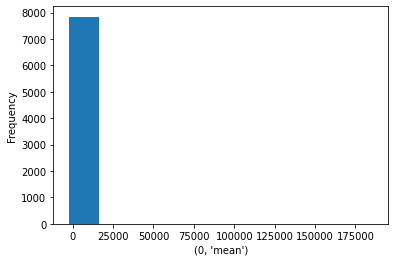

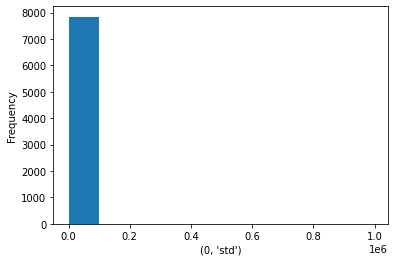

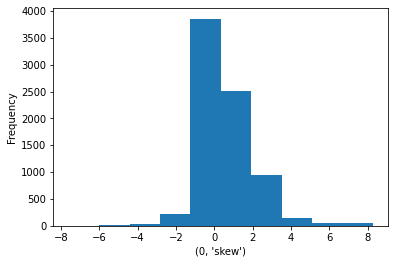

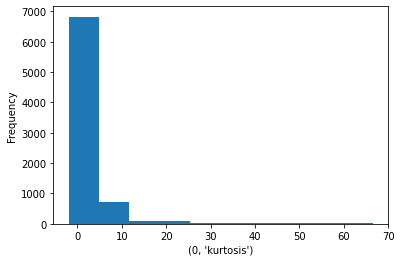

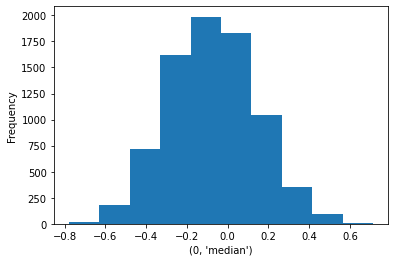

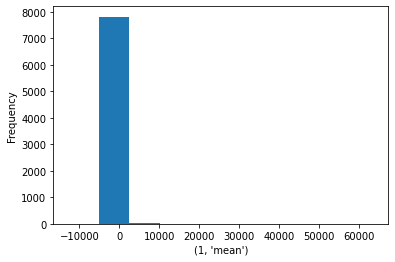

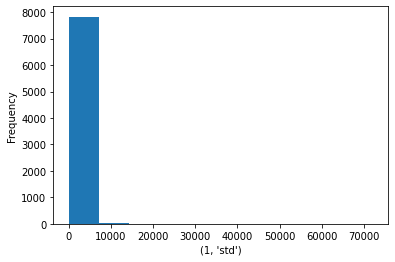

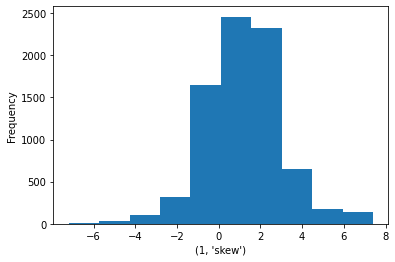

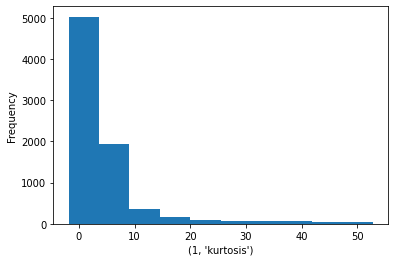

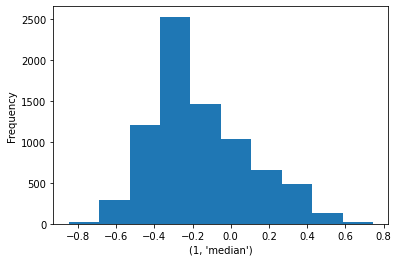

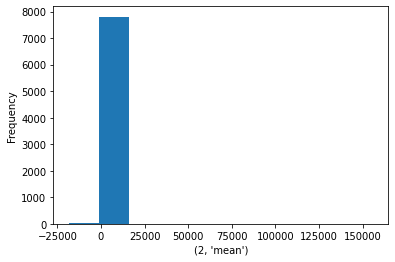

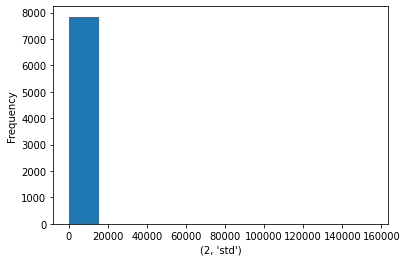

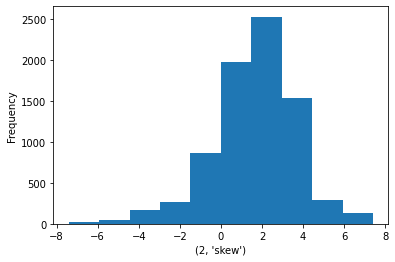

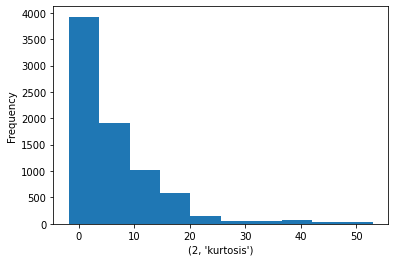

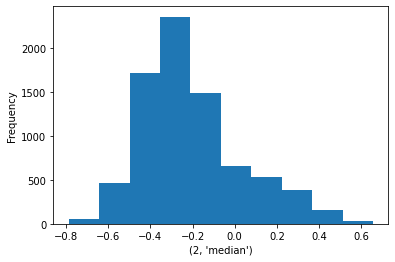

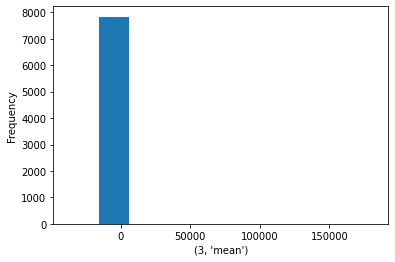

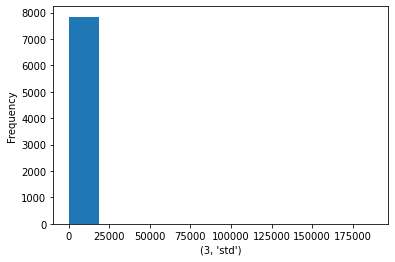

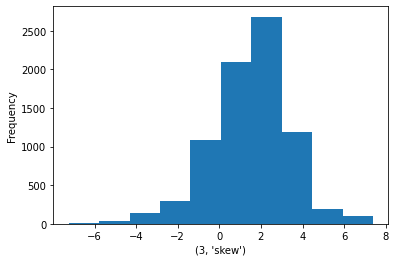

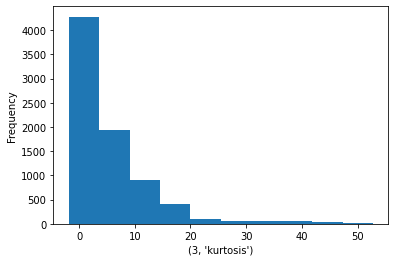

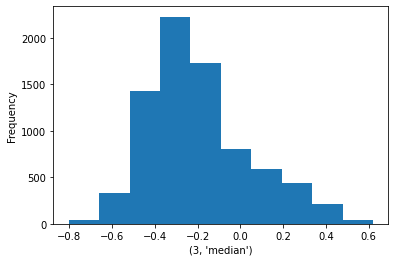

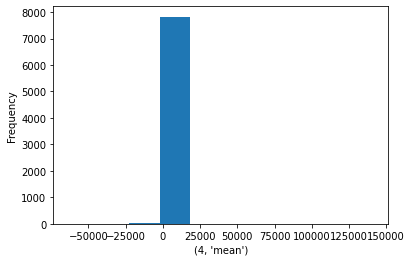

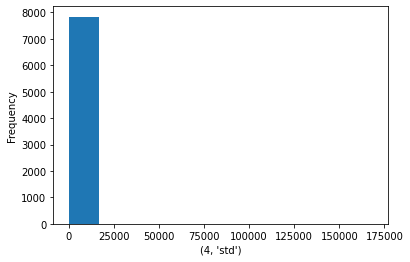

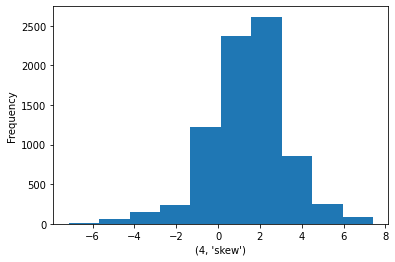

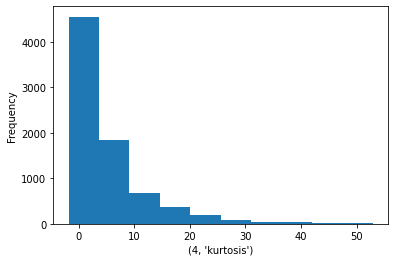

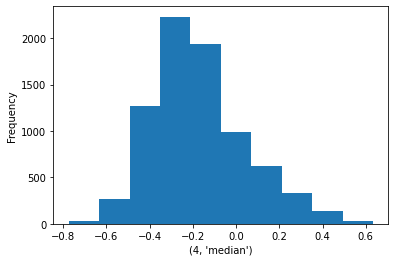

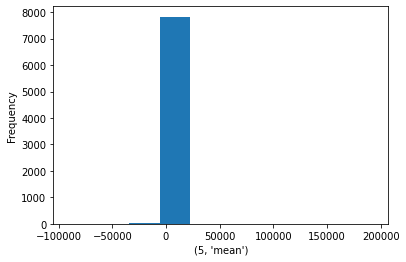

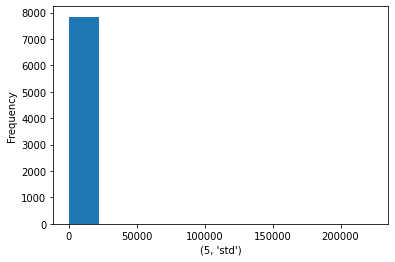

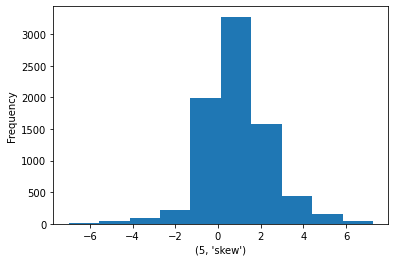

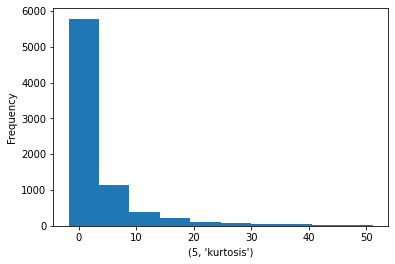

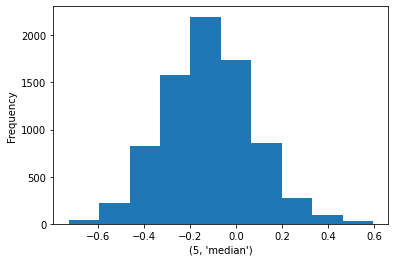

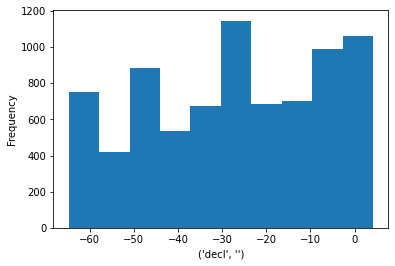

In [ ]:
for i in allfeatures.columns:
  pl.figure()
  pl.hist(allfeatures[i])
  pl.xlabel(i)
  pl.ylabel('Frequency')

# TASK III : Gaussian Processes

Take the time series and fit them with GPs. 
- use the george package goerge (see class demo https://github.com/fedhere/MLTSA22_FBianco/blob/main/Lab5GP/GP_examples.ipynb)
- make sure you use the standardized time series
- make sure you process the uncertainty as well as the data in the standardization!
- choose an appropriate kernel (e.g. the composite one we use in class that enables periodicity as well as stockastic variations)
- take a subset of the time series, ~10, making sure that they are of different types
- fit the GP kernerl to each time series band by band
- collect the best fit parameters and describe their variance - can all the time series be fit reasonably with the same kernel? how would you initialize the fit for the whole ensamble?



In [ ]:
!pip install george

     |████████████████████████████████| 407 kB 5.1 MB/s 


In [ ]:
import george
from george import kernels
from scipy.optimize import minimize

In [266]:
ts_ids = list(metadata[['object_id','target']]
    .groupby('target')
    .agg(list)
    .apply(lambda x: x['object_id'][1], axis=1)
)[:10]
ts_ids

[77157, 23116, 4171, 1632, 11773, 268977, 7703, 139362, 1926, 3041]

In [257]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

In [267]:
results_dict = defaultdict(
    dict
)

for ts_id in tqdm(ts_ids):
  for passband in range(0,6):
    gp_ts = lcvs_norm[
      (lcvs_norm['object_id'] == ts_id) & \
      (lcvs_norm['passband'] == passband)
    ]

    t = gp_ts['mjd']
    y = gp_ts['flux_norm']
    yerr = gp_ts['flux_err_norm']
    t_pred = np.atleast_2d(
        np.linspace(
          gp_ts['mjd'].min(), 
          gp_ts['mjd'].max(), 
          1000
        )
    ).T

    kernel = np.var(y) * kernels.Product(kernels.ExpSquaredKernel(0.5), 
                                        kernels.CosineKernel(1))
    gp = george.GP(kernel)

    gp.compute(t, 0.1*np.abs(y))

    pred, pred_var = gp.predict(y, t_pred, return_var=True)

    result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
    #print(result)
    gp.set_parameter_vector(result.x)

    pred, pred_var = gp.predict(y, t_pred, return_var=True)

    # results_dict[ts_id][passband]['params'] = gp.get_parameter_vector()
    # results_dict[ts_id][passband]['ln-likelihood'] = gp.get_parameter_vector()

    current_params = dict(enumerate(gp.get_parameter_vector()))

    for n_param in current_params:
      results_dict[(ts_id, passband)]['params', n_param] = current_params[n_param]
    results_dict[(ts_id, passband)]['optimization', 'ln-likelihood'] = gp.log_likelihood(y)


    # pl.figure()
    # pl.fill_between(t_pred[:,0], pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
    #                 color="k", alpha=0.2)
    # pl.plot(t_pred[:,0], pred, "k", lw=1.5, alpha=0.5)
    # pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
    # pl.xlabel("x")
    # pl.ylabel("y");

    # print("Optimized parameters {:.2f} {:.2f}".format(*gp.get_parameter_vector()))
    # print("Optimized ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))
    # print()

    

100%|██████████| 10/10 [00:13<00:00,  1.34s/it]


In [253]:
pd.DataFrame.from_dict(results_dict).T

params                        optimization
                    0          1          2 ln-likelihood
35268410  0 -0.051739  -0.876087   1.342184    -14.086353
          1  0.240106   8.994685  14.656197     -4.535449
          2  0.192950   6.559704   0.865042    -20.809481
          3 -0.304114   8.175886  22.713094     -1.641554
          4 -0.451253   9.199776   6.327115     12.167842
          5 -0.447995   8.160576  24.852688     20.387124
39124610  0  0.594316  10.061529   0.627923     -9.501215
          1  0.031933   5.741025   0.491292    -11.714644
          2 -0.203185   4.403234   0.713469    -25.396105
          3 -0.166164  -3.035383   0.319151    -26.246452
          4  0.130115   3.045685   6.622093    -37.044394
          5 -0.152379   0.173766   7.353568    -37.243000
25920     0 -0.095208  -0.227685   0.874992    -39.106694
          1 -0.110915   2.693216   1.066250    -57.233324
          2 -0.137025   3.584378   1.025470    -52.935605
          3 -0.198470   2.584669   0.932898    -60.059691
          4 -0.041621   4.254651   0.926953    -57.872930
          5 -0.117963   2.944525   0.906438    -61.233887
81464     0 -0.096783  -0.305496   6.870241    -38.338930
          1 -0.707209   3.549383   9.870371    -34.937146
          2 -0.359292   5.238710   1.087546    -24.145614
          3 -0.265342   4.989685   1.092942    -29.346130
          4 -0.494926   5.150450  11.103176    -10.816808
          5 -0.270975   2.569661   9.117598    -52.435248
18703334  0 -0.085341  -0.844077   2.142058    -18.169280
          1 -0.142587   1.489237   0.616546    -18.766326
          2  0.122269   5.433279   0.516266    -28.549717
          3  0.016521   4.986712   0.896726    -28.027806
          4 -0.009120   1.335436   0.822769    -36.562450
          5 -0.048496  -0.874834   0.358667    -38.019045
4855013   0 -0.083342   7.077551   2.376070    -15.332822
          1 -0.021824  -0.693147   1.000000    -12.744195
          2 -0.110153   5.989220   0.630660    -22.900549
          3 -0.457373   5.443698  -2.894948    -18.672599
          4  0.756500   7.912420  11.192945    -10.154099
          5 -0.513808   5.805150   9.722096     -2.801772
26338     0 -0.101913  -1.502067   5.269794    -41.741172
          1 -0.140454   1.114906   0.794277    -62.234780
          2 -0.117790   1.612049   8.020478    -60.610357
          3 -0.153889   2.312937   1.190611    -58.336178
          4 -0.074083   1.223456   0.948913    -62.800003
          5 -0.557220   4.475531   1.296940    -52.362270
115381923 0  0.021331  -0.171128   3.883966    -19.589313
          1 -0.150175  -0.693147   1.000000    -13.852274
          2 -0.138776   4.189426   0.485191    -23.930168
          3 -0.198724   4.486861   1.377804    -29.221676
          4 -0.136833   0.863096   1.086710    -43.093112
          5 -0.077243  -0.689250   0.520290    -51.604635
145160    0 -0.051672  -1.589577   5.140936   -101.199630
          1 -0.637480   1.471455   0.557872    -70.740617
          2 -1.001393   3.140130   0.836233    -65.665086
          3 -0.256573   4.253738   0.868901    -69.017761
          4 -0.425723   1.953752   1.588765    -72.069307
          5 -0.492099   2.264932   0.883178    -71.094554
63640666  0 -0.050348  -1.094988   0.841578    -19.682576
          1 -0.066697  -0.693147   1.000000    -12.645407
          2 -0.075182   4.239739   0.513121    -35.267803
          3 -0.180303   6.336506   0.513520    -24.069082
          4 -0.184068   2.548332   9.193797    -33.588525
          5  0.102479   2.476221   8.206432    -46.404052

# CHALLENGE (Extra Credit): fit the 2D time series: 
- create a 2D array for each of the ~10 time series you used earlier: 1 dimension is time the other is wavelength (the bandpass)
- fit a 2D kernel to the time series. 
- show the fits with their uncertainties marginalized along one feature at a time: the fit along the time axis for all 6 bands and the fit along the wavelength axis for a subset of the datapoints.
- (try and make a surface plot  that conveys the relevant info effectively, I find it difficult)